#Word2Vec Embeddings Analysis

In this analysis we inspect the word embeddings obtained with the W2V Skip-Gram method. In particular we want to investigate the amount of redundant / unnecessary information contained in the fixed size word embeddings after having trained them on about 1 billion (940'256'255) tokens from Wikipedia.

To this end, we apply different heuristics to remove values from the embeddings matrix and successively test the modified matrix on the Google Analogical Reasoning dataset. (available here: 
https://word2vec.googlecode.com/svn/trunk/questions-words.txt)

### Basic Setup

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from numpy import exp, dot, zeros, outer, random, dtype, float32 as REAL,\
    uint32, seterr, array, uint8, vstack, argsort, fromstring, sqrt, newaxis,\
    ndarray, empty, sum as np_sum, prod, abs, sort, count_nonzero
from gensim import utils, matutils
from six import iteritems, itervalues, string_types
from gensim.models.word2vec import Word2Vec

### Embedding Matrix
Load the embedding matrix from a local npy-file in the data directory and output basic statistics

In [2]:
model = Word2Vec.load_word2vec_format("../data/model.w2v", fvocab="../data/vocab.w2v", binary=True, norm_only=False)
emb = model.syn0
vocab = model.vocab
print vocab['king'].count
N = emb.shape[0]
d = emb.shape[1]
print model.most_similar(['woman', 'king'], ['man'])
print "Shape: %s" % str(emb.shape)
print "Mean length of Emb: %.3f" % np.mean(np.linalg.norm(emb, axis=1))
print "Mean stddev of lenghts: %.3f" % np.mean(np.std(emb, axis=1))

77550
[(u'queen', 0.7992361187934875), (u'prince', 0.7984243631362915), (u'princess', 0.7928072810173035), (u'monarch', 0.7902592420578003), (u'throne', 0.7746814489364624), (u'consort', 0.7672040462493896), (u'kings', 0.7512421607971191), (u'regnant', 0.7497624158859253), (u'ruler', 0.7438274621963501), (u'pretender', 0.7404688596725464)]
Shape: (148958, 100)
Mean length of Emb: 3.063
Mean stddev of lenghts: 0.305


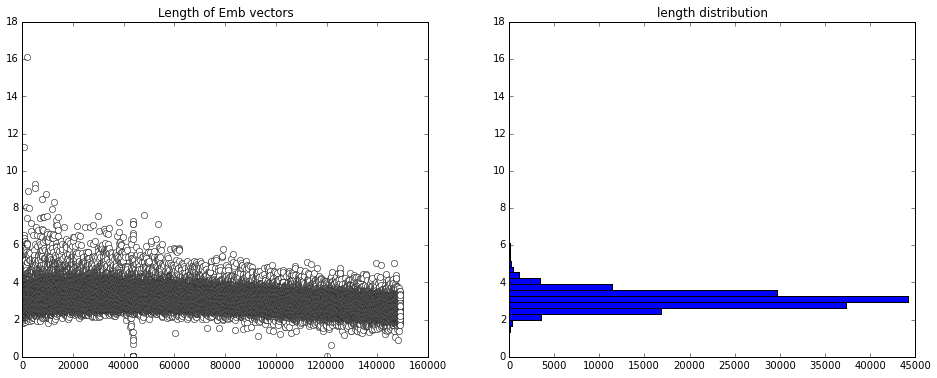

In [3]:
fig = plt.figure(1, figsize=(16,6))  # an empty figure with no axes
ax = fig.add_subplot(121)
ax.set_title("Length of Emb vectors")
lengths = np.linalg.norm(emb, axis=1)
llengths = ax.plot(lengths, 'ow')
ax2 = fig.add_subplot(122)
ax2.set_title("length distribution")
lenhist = ax2.hist(lengths, 50, orientation="horizontal")
plt.show()

### Factors

Let's look at individual factors of the embedding vectors. Embedding vectors have 100 dimensions. Consequently, the meaning of a word is distributed across 100 factors.

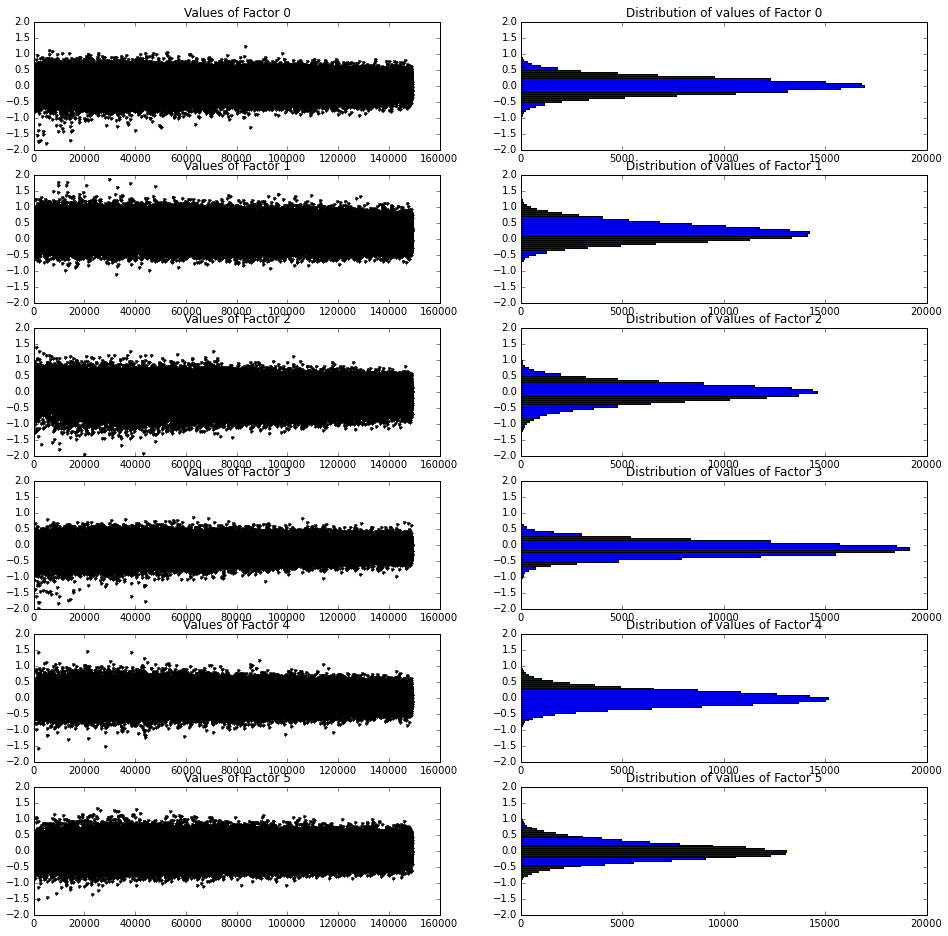

In [4]:
fig = plt.figure(2, figsize=(16,16))
strt_factor = 0
max_factors = 6
for i in range(0, max_factors):
    factorIdx = strt_factor + i
    ax = fig.add_subplot(max_factors,2, (i*2)+1, ylim=[-2.0, 2.0])
    ax.set_title("Values of Factor %d" % factorIdx)
    facDist = emb[:,factorIdx]
    ax.plot(facDist, '.k')
    ax2 = fig.add_subplot(max_factors,2, (i*2)+2, xlim=[0, 20000], ylim=[-2.0, 2.0])
    ax2.set_title("Distribution of values of Factor %d" % factorIdx)
    ax2.hist(facDist, 50, orientation="horizontal")
    
plt.show()

### Correlation Matrix

See if the factors are correlated. (Only for a subset of the whole embedding matrix)

<matplotlib.colorbar.Colorbar instance at 0x11fac23b0>

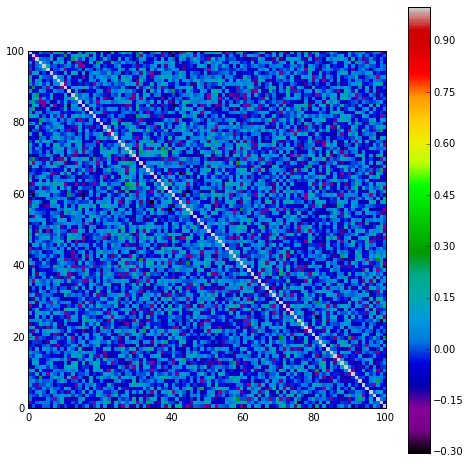

In [5]:
from scipy.spatial.distance import hamming, euclidean, cosine
import matplotlib.cm as CM
semb = emb[:1000]
cmat = np.corrcoef(semb.T)
(N, M) = cmat.shape 
exts = (0, 1 * M, 0, 1 * N)
plt.figure(3, figsize=(8,8))
plt.imshow(cmat, interpolation='nearest', cmap=CM.spectral, extent=exts)
plt.colorbar()

The factors seem to be mostly independent of each other. At least for this linear correlation.

### Google Analogical Reasoning dataset

Next, let's look into the accuracy of the word embeddings for predicting word analogies on a standard dataset.
In this dataset we have thousands of analogy questions like "Rome Italy Athens Greece", where the first pair of words defines a given relation between words. In this case it denotes the capital-of relationship between "Rome" and "Italy". The task is to predict the fourth word in the sequence, given the first three: 

"Rome relates to Italy as Athens relates to _____ ?"

The answer to this question can be retrieved from the word embeddings by vector arithmetic. Knowing the difference vector between "Rome" and "Italy", we simply add it to the vector of "Athens" to obtain a virtual point in embedding space. Then we consider the word of which its vector is closest to this virtual point as the answer to the question. Hopefully, this is "Greece".

Implementation notes: Embeddings are scaled to unit length. Cosine-similarity is used as similarity measure. Only the 50'000 most frequent words in the vocabulary are used - questions that contain an out-of-vocabulary word are ignored.

We use the accuracy computation method as given in the original implementation with minor adaptions due to case-sensitive words in our vocabulary.

In [6]:
class WordAccuracy(object):

    def __init__(self, model, logger):
        self.model = model
        self.syn0 = model.syn0
        self.vocab = model.vocab
        self.index2word = model.index2word
        self.logger = logger
        self.init_sims()

    def init_sims(self, replace=False):
            """
            Precompute L2-normalized vectors.

            If `replace` is set, forget the original vectors and only keep the normalized
            ones = saves lots of memory!

            Note that you **cannot continue training** after doing a replace. The model becomes
            effectively read-only = you can call `most_similar`, `similarity` etc., but not `train`.

            """
            if getattr(self, 'syn0norm', None) is None or replace:
                self.logger.info("precomputing L2-norms of word weight vectors")
                if replace:
                    for i in xrange(self.syn0.shape[0]):
                        self.syn0[i, :] /= sqrt((self.syn0[i, :] ** 2).sum(-1))
                    self.syn0norm = self.syn0
                    if hasattr(self, 'syn1'):
                        del self.syn1
                else:
                    self.syn0norm = (self.syn0 / sqrt((self.syn0 ** 2).sum(-1))[..., newaxis]).astype(REAL)

    def most_similar(self, positive=[], negative=[], topn=10):
        """
        Find the top-N most similar words. Positive words contribute positively towards the
        similarity, negative words negatively.

        This method computes cosine similarity between a simple mean of the projection
        weight vectors of the given words, and corresponds to the `word-analogy` and
        `distance` scripts in the original word2vec implementation.

        Example::

          >>> trained_model.most_similar(positive=['woman', 'king'], negative=['man'])
          [('queen', 0.50882536), ...]

        """
        self.init_sims()

        if isinstance(positive, string_types) and not negative:
            # allow calls like most_similar('dog'), as a shorthand for most_similar(['dog'])
            positive = [positive]

        # add weights for each word, if not already present; default to 1.0 for positive and -1.0 for negative words
        positive = [(word, 1.0) if isinstance(word, string_types + (ndarray,))
                                else word for word in positive]
        negative = [(word, -1.0) if isinstance(word, string_types + (ndarray,))
                                 else word for word in negative]

        # compute the weighted average of all words
        all_words, mean = set(), []
        for word, weight in positive + negative:
            if isinstance(word, ndarray):
                mean.append(weight * word)
            elif word in self.vocab:
                mean.append(weight * self.syn0norm[self.vocab[word].index])
                all_words.add(self.vocab[word].index)
            else:
                raise KeyError("word '%s' not in vocabulary" % word)
        if not mean:
            raise ValueError("cannot compute similarity with no input")
        mean = matutils.unitvec(array(mean).mean(axis=0)).astype(REAL)
        dists = dot(self.syn0norm, mean)
        if not topn:
            return dists
        best = argsort(dists)[::-1][:topn + len(all_words)]
        # ignore (don't return) words from the input
        result = [(self.index2word[sim], float(dists[sim])) for sim in best if sim not in all_words]
        return result[:topn]

    def log_accuracy(self, section):
        correct, incorrect = len(section['correct']), len(section['incorrect'])
        if correct + incorrect > 0:
            self.logger.info("%s: %.1f%% (%i/%i)" %
                (section['section'], 100.0 * correct / (correct + incorrect),
                correct, correct + incorrect))

    def accuracy(self, questions, restrict_vocab=30000, most_similar=most_similar):
        """
        Compute accuracy of the model. `questions` is a filename where lines are
        4-tuples of words, split into sections by ": SECTION NAME" lines.
        See https://code.google.com/p/word2vec/source/browse/trunk/questions-words.txt for an example.

        The accuracy is reported (=printed to log and returned as a list) for each
        section separately, plus there's one aggregate summary at the end.

        Use `restrict_vocab` to ignore all questions containing a word whose frequency
        is not in the top-N most frequent words (default top 30,000).

        This method corresponds to the `compute-accuracy` script of the original C word2vec.

        """
        ok_vocab = dict(sorted(iteritems(self.vocab),
                               key=lambda item: -item[1].count)[:restrict_vocab])
        ok_index = set(v.index for v in itervalues(ok_vocab))

        sections, section = [], None
        for line_no, line in enumerate(utils.smart_open(questions)):
            # TODO: use level3 BLAS (=evaluate multiple questions at once), for speed
            line = utils.to_unicode(line)
            if line.startswith(': '):
                # a new section starts => store the old section
                if section:
                    sections.append(section)
                    self.log_accuracy(section)
                section = {'section': line.lstrip(': ').strip(), 'correct': [], 'incorrect': []}
            else:
                if not section:
                    raise ValueError("missing section header before line #%i in %s" % (line_no, questions))
                try:
                    a, b, c, expected = line.split()#[word.lower() for word in line.split()]  # TODO assumes vocabulary preprocessing uses lowercase, too...
                except:
                    self.logger.info("skipping invalid line #%i in %s" % (line_no, questions))
                if a not in ok_vocab or b not in ok_vocab or c not in ok_vocab or expected not in ok_vocab:
                    self.logger.debug("skipping line #%i with OOV words: %s" % (line_no, line.strip()))
                    continue

                ignore = set(self.vocab[v].index for v in [a, b, c])  # indexes of words to ignore
                predicted = None
                # find the most likely prediction, ignoring OOV words and input words
                for index in argsort(self.most_similar(positive=[b, c], negative=[a], topn=False))[::-1]:
                    if index in ok_index and index not in ignore:
                        predicted = self.index2word[index]
                        if predicted != expected:
                            self.logger.debug("%s: expected %s, predicted %s" % (line.strip(), expected, predicted))
                        break
                if predicted == expected:
                    section['correct'].append((a, b, c, expected))
                else:
                    section['incorrect'].append((a, b, c, expected))
        if section:
            # store the last section, too
            sections.append(section)
            self.log_accuracy(section)

        total = {
            'section': 'total',
            'correct': sum((s['correct'] for s in sections), []),
            'incorrect': sum((s['incorrect'] for s in sections), []),
        }
        self.log_accuracy(total)
        sections.append(total)
        return sections

In [12]:
import logging
import sys
logger = logging.getLogger()
logger.setLevel(logging.INFO)

ch = logging.StreamHandler(sys.stdout)
ch.setLevel(logging.INFO)
formatter = logging.Formatter('%(asctime)s : %(levelname)s : %(message)s')
ch.setFormatter(formatter)
logger.handlers = []
logger.addHandler(ch)
wa = WordAccuracy(model, logger)

strt_percentage = 0.
end_percentage = 1.
step_percentage = 0.1
syn0norm_sorted = sort(abs(wa.syn0norm.flatten()))
l = len(syn0norm_sorted)
results = []
for i in xrange(int(strt_percentage*l), int(end_percentage*l), int(step_percentage*l)):
    percentage = i/float(l)
    threshold_value = syn0norm_sorted[i]
    print "Percentage of zeroed values: %.2f" % (percentage*100.)
    print "Threshold value: %.3f" % threshold_value
    print "Number of zeroes: %d" % i
    wa.syn0norm[abs(wa.syn0norm)<threshold_value] = 0.
    relations = wa.accuracy("../data/questions-words.txt", restrict_vocab=30000)
    result = {'percentage': percentage, 'thresholdValue': threshold_value, 'zeroes': i, 'relations': relations}
    results.append(result)

2015-07-03 13:38:01,752 : INFO : precomputing L2-norms of word weight vectors
Percentage of zeroed values: 0.00
Threshold value: 0.000
Number of zeroes: 0
2015-07-03 13:38:10,783 : INFO : capital-common-countries: 88.7% (449/506)
2015-07-03 13:38:34,342 : INFO : capital-world: 73.5% (1237/1683)
2015-07-03 13:38:34,737 : INFO : currency: 21.4% (6/28)
2015-07-03 13:39:05,272 : INFO : city-in-state: 42.2% (929/2203)
2015-07-03 13:39:09,977 : INFO : family: 74.6% (255/342)
2015-07-03 13:39:18,968 : INFO : gram1-adjective-to-adverb: 31.4% (204/650)
2015-07-03 13:39:22,290 : INFO : gram2-opposite: 29.6% (71/240)
2015-07-03 13:39:35,968 : INFO : gram3-comparative: 72.2% (716/992)
2015-07-03 13:39:42,939 : INFO : gram4-superlative: 67.8% (343/506)
2015-07-03 13:39:54,123 : INFO : gram5-present-participle: 51.8% (421/812)
2015-07-03 13:40:13,109 : INFO : gram6-nationality-adjective: 85.0% (1165/1371)
2015-07-03 13:40:31,660 : INFO : gram7-past-tense: 59.5% (793/1332)
2015-07-03 13:40:45,358 : I

In [41]:
pruning_levels = []
section_names = []
sections_accs = []
for pruning_step in range(len(results)):
    pruning_levels.append(results[pruning_step]['percentage'])
    for section in range(len(results[pruning_step]['relations'])):
        section_name = results[pruning_step]['relations'][section]['section']
        if section_name not in section_names:
            section_names.append(section_name)
            sections_accs.append([])
        acc = float(len(results[pruning_step]['relations'][section]['correct']))/(len(results[pruning_step]['relations'][section]['correct'])+len(results[pruning_step]['relations'][section]['incorrect']))
        sections_accs[section_names.index(section_name)].append(acc)

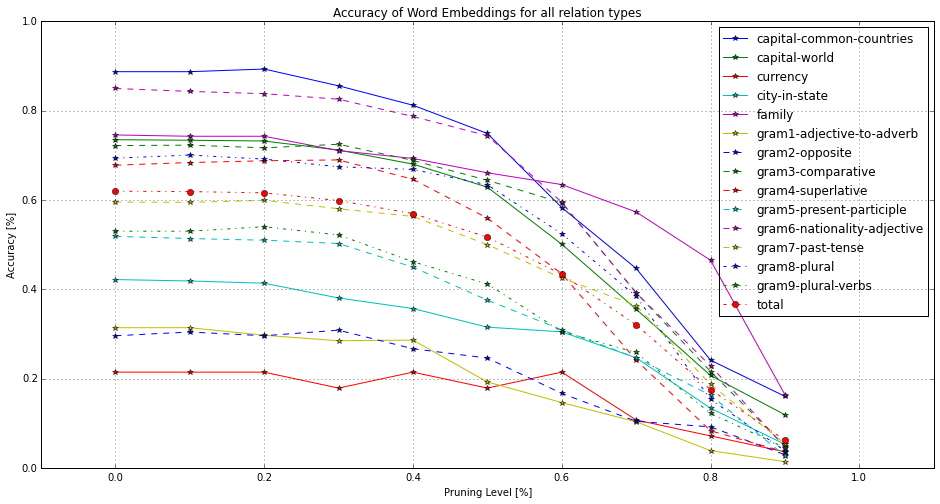

In [58]:
fig = plt.figure(4, figsize=(16,8))
ax = fig.add_subplot(111, xlim=[-0.1, 1.1],ylim=[0.,1.], xlabel="Pruning Level [%]", ylabel="Accuracy [%]")
ax.set_title("Accuracy of Word Embeddings for all relation types")
ax.grid(True)
lineStyles, lineColors = ["-","--","-.",":"], ['b', 'g', 'r', 'c', 'm', 'y']
for i, s in enumerate(section_names):
    lstyle = lineStyles[int(i/len(lineColors))%len(lineStyles)] + ('o' if s == "total" else '*') + lineColors[i%len(lineColors)]                                                                          #lstyle = '-o' if s == "total" else '-*'
    ax.plot(pruning_levels, sections_accs[i], lstyle, label=s)
ax.legend(numpoints=1)
plt.show()

TODO: What happens if we radically set all values above 0 to 1 and all values below zero to 0 and thus produce binary word embeddings? What if we prune each factor independently?